In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("Crimes_-_2001_to_Present.csv")
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [4]:
df = data.copy()

In [5]:
#delete duplicated rows
df.drop_duplicates(subset=['Case Number'], inplace=True)

In [6]:
irrelevant_features = ['ID', 'Case Number', 'Block','IUCR', 'Ward','District','Beat', 'Description', 'Location Description', 'Arrest', 'Domestic','FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location' ]  # Replace with the actual names of the irrelevant features in your dataset
df = df.drop(columns=irrelevant_features, axis = 1)

In [7]:
#drop the nullvalues
df.dropna(inplace=True)

In [8]:
# Define the primary types to remove
types_to_remove = ["NON-CRIMINAL", "NON - CRIMINAL", "NON-CRIMINAL (SUBJECT SPECIFIED)"]

# Remove samples with the specified primary types
df = df[~df["Primary Type"].isin(types_to_remove)]

In [9]:
# Convert "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Extract day and month
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

In [10]:
df = df[(df['Date'].dt.year >= 2018) & (df['Date'].dt.year <= 2022)]

In [11]:
df = df[df['Community Area'] != 0]

In [12]:
# Group by Community Area, Day, Month, and Year, and apply count aggregation
df = df.groupby(['Community Area', 'Day', 'Month', 'Year']).agg({'Community Area': 'count'})

# Rename the count column
df = df.rename(columns={'Community Area': 'Crime_Count'})

# Reset the index to convert the group labels back to columns
df = df.reset_index()

In [13]:
df

,Community Area,Day,Month,Year,Crime_Count
0,1.0,1,1,2018,12
1,1.0,1,1,2019,18
2,1.0,1,1,2020,12
3,1.0,1,1,2021,14
4,1.0,1,1,2022,16
...,...,...,...,...,...
133641,77.0,31,12,2018,3
133642,77.0,31,12,2019,8
133643,77.0,31,12,2020,7
133644,77.0,31,12,2021,6


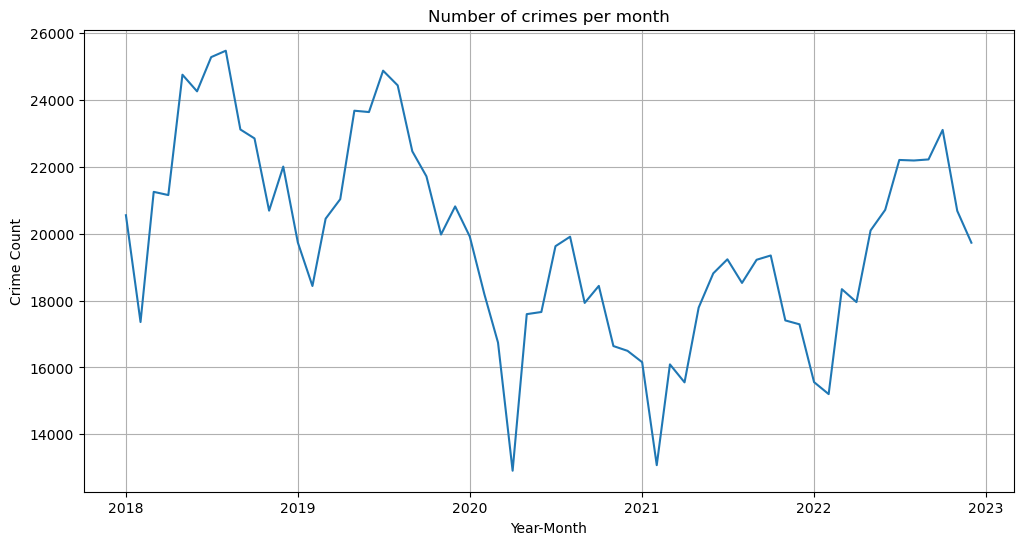

In [15]:
filtered_data2= df.copy()
filtered_data2['Day'] = 1

# Create a datetime column for monthly data
filtered_data2['Date'] = pd.to_datetime(filtered_data2[['Year', 'Month', 'Day']], format='%Y-%m-%d')

# Group the data by month and sum the crime counts for each month
monthly_data = filtered_data2.groupby('Date')['Crime_Count'].sum()

# Plot the time series chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data.values, linestyle='-')
plt.title(f'Number of crimes per month')
plt.xlabel('Year-Month')
plt.ylabel('Crime Count')
plt.grid(True)

In [16]:
import calendar
community_areas = range(1, 78)  # Community areas from 1 to 77
years = range(2018, 2023)  # Years from 2018 to 2022

all_combinations = [(area, year) for area in community_areas for year in years]

# Convert date columns to a datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Group the DataFrame by Community Area and Year
grouped = df.groupby(['Community Area', 'Year'])

# Create a list to store missing rows
missing_rows = []

# Loop through all combinations and find missing dates
for area, year in all_combinations:
    if (area, year) in grouped.groups:
        dates_present = set(grouped.get_group((area, year))['Date'])
        dates_expected = set(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31'))
        missing_dates = dates_expected - dates_present

        for date in missing_dates:
            day, month = date.day, date.month
            missing_rows.append({
                'Community Area': area,
                'Day': day,
                'Month': month,
                'Year': year,
                'Crime_Count': 0
            })

# Create a DataFrame for missing rows
missing_df = pd.DataFrame(missing_rows)

# Combine missing_df with the original DataFrame
combined_df = pd.concat([df, missing_df], ignore_index=True)

# Sort the DataFrame by date
combined_df = combined_df.sort_values(by=["Year", "Month", "Day"]).reset_index(drop=True)

df = combined_df.copy()

In [17]:
df

,Community Area,Day,Month,Year,Crime_Count,Date
0,1.0,1,1,2018,12,2018-01-01
1,2.0,1,1,2018,14,2018-01-01
2,3.0,1,1,2018,18,2018-01-01
3,4.0,1,1,2018,10,2018-01-01
4,5.0,1,1,2018,6,2018-01-01
...,...,...,...,...,...,...
140597,76.0,31,12,2022,1,2022-12-31
140598,77.0,31,12,2022,9,2022-12-31
140599,12.0,31,12,2022,0,NaT
140600,17.0,31,12,2022,0,NaT


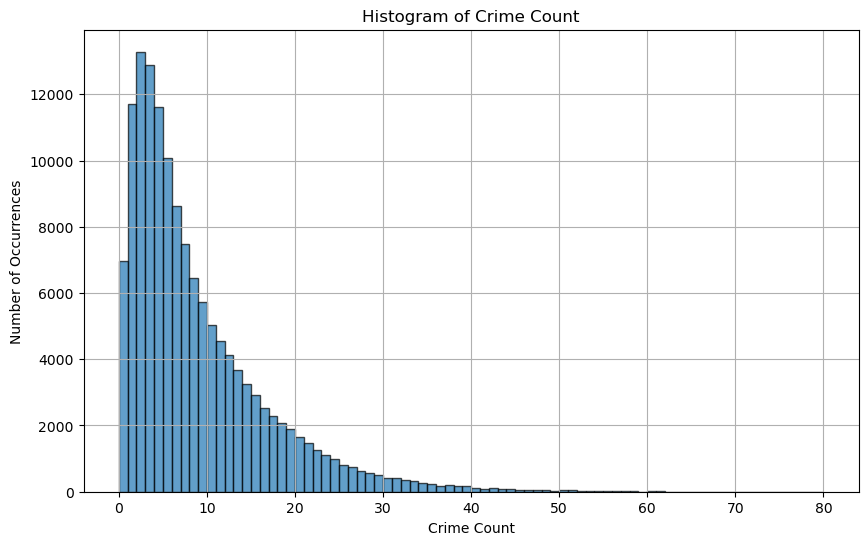

In [18]:
# Define the range for the x-axis
x_min = 0  # Minimum Crime Count value
x_max = 80  # Maximum Crime Count value

# Create a histogram for 'Crime Count' within the specified range
plt.figure(figsize=(10, 6))
plt.hist(df['Crime_Count'], bins=range(x_min, x_max + 1), edgecolor='k', alpha=0.7)
plt.title('Histogram of Crime Count')
plt.xlabel('Crime Count')
plt.ylabel('Number of Occurrences')
plt.grid(True)

In [20]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['Day_of_week'] = df['Date'].dt.day_name()

In [21]:
# Function to determine if a day is a weekend or not
def is_weekend(day_of_week):
    return day_of_week in ['Saturday', 'Sunday']

# Apply the function and create a new column 'is_weekend'
df['is_weekend'] = df['Day_of_week'].apply(is_weekend)

In [22]:
#Mapping seasons from month of crime
season_map = {
    (3,4,5) : 'Spring',
    (6,7,8) : 'Summer',
    (9,10,11) : 'Fall',
    (12,1,2) : 'Winter'
}
season_mapping = {}
for keys, values in season_map.items():
    for key in keys:
        season_mapping[key] = values
df['season'] = df.Month.map(season_mapping)

In [23]:
df

,Community Area,Day,Month,Year,Crime_Count,Date,Day_of_week,is_weekend,season
0,1.0,1,1,2018,12,2018-01-01,Monday,False,Winter
1,2.0,1,1,2018,14,2018-01-01,Monday,False,Winter
2,3.0,1,1,2018,18,2018-01-01,Monday,False,Winter
3,4.0,1,1,2018,10,2018-01-01,Monday,False,Winter
4,5.0,1,1,2018,6,2018-01-01,Monday,False,Winter
...,...,...,...,...,...,...,...,...,...
140597,76.0,31,12,2022,1,2022-12-31,Saturday,True,Winter
140598,77.0,31,12,2022,9,2022-12-31,Saturday,True,Winter
140599,12.0,31,12,2022,0,2022-12-31,Saturday,True,Winter
140600,17.0,31,12,2022,0,2022-12-31,Saturday,True,Winter


In [24]:
# Count the occurrences of each unique value in 'Crime_Count'
value_counts = df['Crime_Count'].value_counts()

print("Number of occurrences of each unique value in 'Crime Count':")
print(value_counts)

Number of occurrences of each unique value in 'Crime Count':
2     13285
3     12876
1     11715
4     11606
5     10085
      ...  
76        1
69        1
80        1
85        1
86        1
Name: Crime_Count, Length: 94, dtype: int64


In [25]:
test_df=df.copy()

In [26]:
# restart here
df=test_df.copy()

In [28]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Create lag features for crime count from 5 and 364 days ago for each community area
df['Crime_Count_Lag364'] = df.groupby('Community Area')['Crime_Count'].shift(364)
df['Crime_Count_Lag5'] = df.groupby('Community Area')['Crime_Count'].shift(5)

In [29]:
# Convert day, month, and year columns to a datetime format
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Sort the data by date within each community area
df.sort_values(by=['Community Area', 'Date'], inplace=True)

# Define the rolling window size (e.g., 7 days)
window_size = 30

# Create a new DataFrame to store the rolling window results
rolling_window_data = pd.DataFrame()

# Iterate through each community area
for area in df['Community Area'].unique():
    area_data = df[df['Community Area'] == area]
    
    # Apply rolling window calculation
    area_data['Rolling_Crime_Count'] = area_data['Crime_Count'].rolling(window=window_size+5, min_periods=1).apply(lambda x: x[:-5].mean(), raw=True)
    
    rolling_window_data = pd.concat([rolling_window_data, area_data])

# Display the rolling window data
df = rolling_window_data.copy()

In [30]:
df

,Community Area,Day,Month,Year,Crime_Count,Date,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count
0,1.0,1,1,2018,12,2018-01-01,Monday,False,Winter,NaN,NaN,NaN
77,1.0,2,1,2018,4,2018-01-02,Tuesday,False,Winter,NaN,NaN,NaN
154,1.0,3,1,2018,12,2018-01-03,Wednesday,False,Winter,NaN,NaN,NaN
231,1.0,4,1,2018,4,2018-01-04,Thursday,False,Winter,NaN,NaN,NaN
308,1.0,5,1,2018,8,2018-01-05,Friday,False,Winter,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
140289,77.0,27,12,2022,7,2022-12-27,Tuesday,False,Winter,6.0,8.0,8.533333
140366,77.0,28,12,2022,7,2022-12-28,Wednesday,False,Winter,3.0,2.0,8.300000
140445,77.0,29,12,2022,11,2022-12-29,Thursday,False,Winter,10.0,6.0,8.266667
140523,77.0,30,12,2022,10,2022-12-30,Friday,False,Winter,6.0,4.0,8.100000


In [33]:
df.dropna(inplace=True)
df

,Community Area,Day,Month,Year,Crime_Count,Date,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count
28028,1.0,31,12,2018,11,2018-12-31,Monday,False,Winter,12.0,12.0,9.866667
28105,1.0,1,1,2019,18,2019-01-01,Tuesday,False,Winter,4.0,6.0,9.700000
28182,1.0,2,1,2019,8,2019-01-02,Wednesday,False,Winter,12.0,8.0,9.566667
28259,1.0,3,1,2019,11,2019-01-03,Thursday,False,Winter,4.0,7.0,9.333333
28336,1.0,4,1,2019,8,2019-01-04,Friday,False,Winter,8.0,10.0,9.466667
...,...,...,...,...,...,...,...,...,...,...,...,...
140289,77.0,27,12,2022,7,2022-12-27,Tuesday,False,Winter,6.0,8.0,8.533333
140366,77.0,28,12,2022,7,2022-12-28,Wednesday,False,Winter,3.0,2.0,8.300000
140445,77.0,29,12,2022,11,2022-12-29,Thursday,False,Winter,10.0,6.0,8.266667
140523,77.0,30,12,2022,10,2022-12-30,Friday,False,Winter,6.0,4.0,8.100000


In [34]:
import math
df["Rolling_Crime_Count"] = df["Rolling_Crime_Count"].apply(math.ceil)

In [35]:
df.dropna(inplace=True)
df

,Community Area,Day,Month,Year,Crime_Count,Date,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count
28028,1.0,31,12,2018,11,2018-12-31,Monday,False,Winter,12.0,12.0,10
28105,1.0,1,1,2019,18,2019-01-01,Tuesday,False,Winter,4.0,6.0,10
28182,1.0,2,1,2019,8,2019-01-02,Wednesday,False,Winter,12.0,8.0,10
28259,1.0,3,1,2019,11,2019-01-03,Thursday,False,Winter,4.0,7.0,10
28336,1.0,4,1,2019,8,2019-01-04,Friday,False,Winter,8.0,10.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
140289,77.0,27,12,2022,7,2022-12-27,Tuesday,False,Winter,6.0,8.0,9
140366,77.0,28,12,2022,7,2022-12-28,Wednesday,False,Winter,3.0,2.0,9
140445,77.0,29,12,2022,11,2022-12-29,Thursday,False,Winter,10.0,6.0,9
140523,77.0,30,12,2022,10,2022-12-30,Friday,False,Winter,6.0,4.0,9


In [36]:
# from https://fred.stlouisfed.org/series/CHIC917URN
data2 = pd.read_csv("CHIC917URN.csv")
data2.head()

,DATE,CHIC917URN
0,1990-01-01,6.9
1,1990-02-01,6.6
2,1990-03-01,6.3
3,1990-04-01,6.5
4,1990-05-01,6.1


In [37]:
# Convert 'DATE' column to datetime format for both DataFrames
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
data2['DATE'] = pd.to_datetime(data2['DATE'])

# Merge the two DataFrames on the 'Date' column
df = pd.merge(df, data2, left_on='Date', right_on='DATE', how='inner')

# Drop the redundant 'Date' and 'DATE' columns
df.drop(['Date', 'DATE'], axis=1, inplace=True)

In [38]:
df.rename(columns={'CHIC917URN': 'Unemployment_Rate'}, inplace=True)

In [39]:
import holidays
country_code = 'US'  
holiday_obj = holidays.CountryHoliday(country_code)

# Convert 'Month', 'Day', and 'Year' columns to datetime format for holiday checking
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Check if each date is a holiday and create a new column 'Is_Holiday'
df['Is_Holiday'] = df['Date'].apply(lambda x: x in holiday_obj)

# Drop the 'Date' column if you no longer need it
df.drop(['Date'], axis=1, inplace=True)

In [40]:
df

,Community Area,Day,Month,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday
0,1.0,31,12,2018,11,Monday,False,Winter,12.0,12.0,10,4.0,False
1,2.0,31,12,2018,5,Monday,False,Winter,14.0,10.0,11,4.0,False
2,3.0,31,12,2018,4,Monday,False,Winter,18.0,6.0,11,4.0,False
3,4.0,31,12,2018,4,Monday,False,Winter,10.0,4.0,5,4.0,False
4,5.0,31,12,2018,4,Monday,False,Winter,6.0,2.0,4,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112569,77.0,27,12,2022,7,Tuesday,False,Winter,6.0,8.0,9,4.1,False
112570,77.0,28,12,2022,7,Wednesday,False,Winter,3.0,2.0,9,4.1,False
112571,77.0,29,12,2022,11,Thursday,False,Winter,10.0,6.0,9,4.1,False
112572,77.0,30,12,2022,10,Friday,False,Winter,6.0,4.0,9,4.1,False


In [41]:
data3 = pd.read_csv("Beach_Weather_Stations_-_Automated_Sensors.csv")

In [42]:
data3.head()

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
0,63rd Street Weather Station,09/27/2018 10:00:00 AM,16.40,12.2,61,0.0,0.0,260.3,0.0,231,2.5,4.7,996.3,484,356.0,11.9,09/27/2018 10:00 AM,63rdStreetWeatherStation201809271000
1,63rd Street Weather Station,09/27/2018 11:00:00 AM,17.10,11.5,51,0.0,0.0,260.3,0.0,244,3.6,5.7,995.4,468,356.0,11.9,09/27/2018 11:00 AM,63rdStreetWeatherStation201809271100
2,63rd Street Weather Station,09/27/2018 01:00:00 PM,18.20,12.4,51,0.0,0.0,260.3,0.0,248,3.1,5.3,994.8,377,355.0,11.9,09/27/2018 1:00 PM,63rdStreetWeatherStation201809271300
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,NaN,39,NaN,0.0,NaN,NaN,249,1.4,2.3,993.6,0,NaN,15.1,09/27/2018 1:00 PM,FosterWeatherStation201809271300
4,63rd Street Weather Station,09/27/2018 03:00:00 PM,19.50,13.0,47,0.0,0.0,260.3,0.0,249,3.1,5.7,992.9,461,355.0,11.9,09/27/2018 3:00 PM,63rdStreetWeatherStation201809271500


In [43]:
columns_to_keep = ['Station Name', 'Humidity', 'Air Temperature', 'Measurement Timestamp']
data3 = data3[columns_to_keep]

In [44]:
# Convert 'Measurement Timestamp' to datetime format
data3['Measurement Timestamp'] = pd.to_datetime(data3['Measurement Timestamp'])

# Group by date and calculate the average humidity and air temperature per day
average_data = data3.groupby(data3['Measurement Timestamp'].dt.date).agg({'Humidity': 'mean', 'Air Temperature': 'mean'})

# Create a new DataFrame with the calculated average values
average_df = pd.DataFrame(average_data).reset_index()
average_df.rename(columns={'Measurement Timestamp': 'Date'}, inplace=True)
average_df

,Date,Humidity,Air Temperature
0,2015-04-25,86.000000,7.000000
1,2015-04-30,76.000000,6.100000
2,2015-05-22,56.937500,9.695000
3,2015-05-23,48.925926,15.784000
4,2015-05-24,65.902439,16.507368
...,...,...,...
2660,2023-08-15,74.636364,20.187500
2661,2023-08-16,55.155556,22.890889
2662,2023-08-17,58.354167,22.049792
2663,2023-08-18,53.435897,20.595385


In [46]:
average_df['Date'] = pd.to_datetime(average_df['Date'])
average_df = average_df.loc[(average_df['Date'].dt.year >= 2019) & (average_df['Date'].dt.year <= 2022)]
average_df.set_index('Date', inplace=True)

# Generate a complete date range from the minimum to the maximum date
complete_date_range = pd.date_range(start=average_df.index.min(), end=average_df.index.max(), freq='D')

# Reindex the DataFrame with the complete date range
average_df = average_df.reindex(complete_date_range)

# Reset the index for the DataFrame
average_df.reset_index(inplace=True)
average_df.rename(columns={'index': 'Date'}, inplace=True)

# Change the 'Date' column to datetime format
average_df['Date'] = pd.to_datetime(average_df['Date'])

In [47]:
average_df

,Date,Humidity,Air Temperature
0,2019-01-01,82.041667,-0.538125
1,2019-01-02,78.234043,-0.967447
2,2019-01-03,70.562500,0.733333
3,2019-01-04,62.645833,4.921042
4,2019-01-05,68.375000,6.444583
...,...,...,...
1456,2022-12-27,65.916667,-6.739792
1457,2022-12-28,63.377778,3.200667
1458,2022-12-29,76.553191,11.638298
1459,2022-12-30,73.125000,7.201667


In [48]:
average_df['Humidity'].fillna(method='ffill', inplace=True)
average_df['Air Temperature'].fillna(method='ffill', inplace=True)

In [49]:
rows_with_null = average_df[average_df['Air Temperature'].isnull()]

print(rows_with_null)

Empty DataFrame
Columns: [Date, Humidity, Air Temperature]
Index: []


In [50]:
average_df['Date'] = pd.to_datetime(average_df['Date'])

# Generate a complete date range from the minimum to the maximum date
complete_date_range = pd.date_range(start=average_df['Date'].min(), end=average_df['Date'].max(), freq='D')

# Identify missing dates by finding the set difference between the complete range and existing dates
missing_dates = list(set(complete_date_range) - set(average_df['Date']))

print("Missing dates:")
for missing_date in missing_dates:
    print(missing_date)

Missing dates:


In [51]:
df

,Community Area,Day,Month,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday
0,1.0,31,12,2018,11,Monday,False,Winter,12.0,12.0,10,4.0,False
1,2.0,31,12,2018,5,Monday,False,Winter,14.0,10.0,11,4.0,False
2,3.0,31,12,2018,4,Monday,False,Winter,18.0,6.0,11,4.0,False
3,4.0,31,12,2018,4,Monday,False,Winter,10.0,4.0,5,4.0,False
4,5.0,31,12,2018,4,Monday,False,Winter,6.0,2.0,4,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112569,77.0,27,12,2022,7,Tuesday,False,Winter,6.0,8.0,9,4.1,False
112570,77.0,28,12,2022,7,Wednesday,False,Winter,3.0,2.0,9,4.1,False
112571,77.0,29,12,2022,11,Thursday,False,Winter,10.0,6.0,9,4.1,False
112572,77.0,30,12,2022,10,Friday,False,Winter,6.0,4.0,9,4.1,False


In [52]:
average_df['Date'] = pd.to_datetime(average_df['Date'])

# Merge the DataFrames based on common columns
df = pd.merge(df, average_df, left_on=['Day', 'Month', 'Year'], right_on=[average_df['Date'].dt.day, average_df['Date'].dt.month, average_df['Date'].dt.year])

# Drop the duplicate 'Date' columns after merging
df.drop(columns=['Date'], inplace=True)
df

,Community Area,Day,Month,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature
0,1.0,1,1,2019,18,Tuesday,False,Winter,4.0,6.0,10,5.1,True,82.041667,-0.538125
1,2.0,1,1,2019,10,Tuesday,False,Winter,11.0,9.0,11,5.1,True,82.041667,-0.538125
2,3.0,1,1,2019,18,Tuesday,False,Winter,6.0,8.0,11,5.1,True,82.041667,-0.538125
3,4.0,1,1,2019,5,Tuesday,False,Winter,9.0,3.0,5,5.1,True,82.041667,-0.538125
4,5.0,1,1,2019,6,Tuesday,False,Winter,4.0,3.0,4,5.1,True,82.041667,-0.538125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112492,73.0,31,12,2022,14,Saturday,True,Winter,8.0,2.0,9,4.1,False,78.375000,0.755208
112493,74.0,31,12,2022,2,Saturday,True,Winter,3.0,2.0,2,4.1,False,78.375000,0.755208
112494,75.0,31,12,2022,5,Saturday,True,Winter,8.0,4.0,6,4.1,False,78.375000,0.755208
112495,76.0,31,12,2022,1,Saturday,True,Winter,2.0,5.0,6,4.1,False,78.375000,0.755208


In [53]:
# Function to calculate day of the year
def day_of_year(month, day):
    days_in_month = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    day = sum(days_in_month[:month]) + day
    return day

# Create a new column 'DayOfYear' using the day_of_year function
df['DayOfYear'] = df.apply(lambda row: day_of_year(row['Month'], row['Day']), axis=1)

# Convert 'DayOfYear' column to integers
df['DayOfYear'] = df['DayOfYear'].astype(int)

In [54]:
df

,Community Area,Day,Month,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature,DayOfYear
0,1.0,1,1,2019,18,Tuesday,False,Winter,4.0,6.0,10,5.1,True,82.041667,-0.538125,1
1,2.0,1,1,2019,10,Tuesday,False,Winter,11.0,9.0,11,5.1,True,82.041667,-0.538125,1
2,3.0,1,1,2019,18,Tuesday,False,Winter,6.0,8.0,11,5.1,True,82.041667,-0.538125,1
3,4.0,1,1,2019,5,Tuesday,False,Winter,9.0,3.0,5,5.1,True,82.041667,-0.538125,1
4,5.0,1,1,2019,6,Tuesday,False,Winter,4.0,3.0,4,5.1,True,82.041667,-0.538125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112492,73.0,31,12,2022,14,Saturday,True,Winter,8.0,2.0,9,4.1,False,78.375000,0.755208,366
112493,74.0,31,12,2022,2,Saturday,True,Winter,3.0,2.0,2,4.1,False,78.375000,0.755208,366
112494,75.0,31,12,2022,5,Saturday,True,Winter,8.0,4.0,6,4.1,False,78.375000,0.755208,366
112495,76.0,31,12,2022,1,Saturday,True,Winter,2.0,5.0,6,4.1,False,78.375000,0.755208,366


In [55]:
# Create a new column 'Date' with the date represented as a string (e.g., "YYYYMMDD")
df['Date'] = df['Year'].astype(str) + df['Month'].astype(str).str.zfill(2) + df['Day'].astype(str).str.zfill(2)

# Sort the DataFrame by the 'Date' column in ascending order
df_sorted = df.sort_values(by='Date', ascending=True)

# Drop the temporary 'Date' column if not needed
df_sorted.drop(columns='Date', inplace=True)

df=df_sorted.copy()

In [56]:
df

,Community Area,Day,Month,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature,DayOfYear
0,1.0,1,1,2019,18,Tuesday,False,Winter,4.0,6.0,10,5.1,True,82.041667,-0.538125,1
55,56.0,1,1,2019,7,Tuesday,False,Winter,2.0,5.0,7,5.1,True,82.041667,-0.538125,1
54,55.0,1,1,2019,4,Tuesday,False,Winter,0.0,1.0,2,5.1,True,82.041667,-0.538125,1
53,54.0,1,1,2019,4,Tuesday,False,Winter,4.0,1.0,4,5.1,True,82.041667,-0.538125,1
52,53.0,1,1,2019,19,Tuesday,False,Winter,12.0,9.0,10,5.1,True,82.041667,-0.538125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112442,23.0,31,12,2022,19,Saturday,True,Winter,14.0,7.0,17,4.1,False,78.375000,0.755208,366
112441,22.0,31,12,2022,11,Saturday,True,Winter,9.0,7.0,13,4.1,False,78.375000,0.755208,366
112440,21.0,31,12,2022,6,Saturday,True,Winter,8.0,0.0,7,4.1,False,78.375000,0.755208,366
112447,28.0,31,12,2022,31,Saturday,True,Winter,26.0,8.0,27,4.1,False,78.375000,0.755208,366


In [57]:
irrelevant_features = ['Day', 'Month']  # Replace with the actual names of the irrelevant features in your dataset
df = df.drop(columns=irrelevant_features, axis = 1)

In [58]:
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear']/366.0)

In [59]:
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear']/366.0)

In [60]:
df

,Community Area,Year,Crime_Count,Day_of_week,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature,DayOfYear,DayOfYear_cos,DayOfYear_sin
0,1.0,2019,18,Tuesday,False,Winter,4.0,6.0,10,5.1,True,82.041667,-0.538125,1,0.999853,1.716633e-02
55,56.0,2019,7,Tuesday,False,Winter,2.0,5.0,7,5.1,True,82.041667,-0.538125,1,0.999853,1.716633e-02
54,55.0,2019,4,Tuesday,False,Winter,0.0,1.0,2,5.1,True,82.041667,-0.538125,1,0.999853,1.716633e-02
53,54.0,2019,4,Tuesday,False,Winter,4.0,1.0,4,5.1,True,82.041667,-0.538125,1,0.999853,1.716633e-02
52,53.0,2019,19,Tuesday,False,Winter,12.0,9.0,10,5.1,True,82.041667,-0.538125,1,0.999853,1.716633e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112442,23.0,2022,19,Saturday,True,Winter,14.0,7.0,17,4.1,False,78.375000,0.755208,366,1.000000,-2.449294e-16
112441,22.0,2022,11,Saturday,True,Winter,9.0,7.0,13,4.1,False,78.375000,0.755208,366,1.000000,-2.449294e-16
112440,21.0,2022,6,Saturday,True,Winter,8.0,0.0,7,4.1,False,78.375000,0.755208,366,1.000000,-2.449294e-16
112447,28.0,2022,31,Saturday,True,Winter,26.0,8.0,27,4.1,False,78.375000,0.755208,366,1.000000,-2.449294e-16


In [61]:
def binary_encoding(col_name):
    # Perform Binary Numerical Encoding
    category_to_binary = {}
    binary_repr = []

    for category in df[col_name]:
        if category not in category_to_binary:
            category_to_binary[category] = bin(len(category_to_binary))[2:].zfill(len(bin(len(category_to_binary))) - 2)
        binary_repr.append(category_to_binary[category])

    # Store binary representation in a single feature
    df[col_name] = binary_repr
    df[col_name] = df[col_name].astype(int)

In [62]:
binary_encoding('Community Area')

In [63]:
binary_encoding('season')

In [64]:
binary_encoding('is_weekend')

In [65]:
binary_encoding('Is_Holiday')

In [66]:
irrelevant_features = ['DayOfYear' ]  # Replace with the actual names of the irrelevant features in your dataset
df = df.drop(columns=irrelevant_features, axis = 1)

In [67]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the days_of_week data
encoder.fit(df['Day_of_week'])

# Transform the data using the encoder
df['Day_of_week'] = encoder.transform(df['Day_of_week'])

In [68]:
df['Day_of_week_sin'] = np.sin(2 * np.pi * df['Day_of_week']/7.0)
df['Day_of_week_cos'] = np.cos(2 * np.pi * df['Day_of_week']/7.0)
irrelevant_features = ['Day_of_week']  # Replace with the actual names of the irrelevant features in your dataset
df = df.drop(columns=irrelevant_features, axis = 1)

In [69]:
X = df.drop('Crime_Count', axis=1).values
y = df['Crime_Count'].values

print(X.shape)
print(y.shape)

(112497, 15)
(112497,)


In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

In [71]:
X_train_df = pd.DataFrame(X_test, columns=['Community Area','Year','is_weekend','season','Crime_Count_Lag364','Crime_Count_Lag5','Rolling_Crime_Count','Unemployment_Rate','Is_Holiday','Humidity','Air Temperature',
                                           'DayOfYear_cos','DayOfYear_sin','Day_of_week_sin','Day_of_week_cos'
                                        ])
X_train_df

,Community Area,Year,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature,DayOfYear_cos,DayOfYear_sin,Day_of_week_sin,Day_of_week_cos
0,1000101.0,2022.0,1.0,10.0,8.0,15.0,10.0,5.0,1.0,82.642857,26.032429,-0.804962,-5.933268e-01,0.433884,-0.900969
1,1000110.0,2022.0,1.0,10.0,17.0,15.0,13.0,5.0,1.0,82.642857,26.032429,-0.804962,-5.933268e-01,0.433884,-0.900969
2,1000111.0,2022.0,1.0,10.0,40.0,46.0,35.0,5.0,1.0,82.642857,26.032429,-0.804962,-5.933268e-01,0.433884,-0.900969
3,1001000.0,2022.0,1.0,10.0,14.0,29.0,22.0,5.0,1.0,82.642857,26.032429,-0.804962,-5.933268e-01,0.433884,-0.900969
4,1001001.0,2022.0,1.0,10.0,20.0,17.0,16.0,5.0,1.0,82.642857,26.032429,-0.804962,-5.933268e-01,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,1001001.0,2022.0,1.0,0.0,14.0,7.0,17.0,4.1,1.0,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
11246,1001010.0,2022.0,1.0,0.0,9.0,7.0,13.0,4.1,1.0,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
11247,1001011.0,2022.0,1.0,0.0,8.0,0.0,7.0,4.1,1.0,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
11248,1001100.0,2022.0,1.0,0.0,26.0,8.0,27.0,4.1,1.0,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521


In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
from sklearn.preprocessing import MinMaxScaler
# Create the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform X_train
X_train_normalized = scaler.fit_transform(X_train)

# Transform X_test using the same scaler
X_test_normalized = scaler.transform(X_test)

In [86]:
columns_to_describe = ['Unemployment_Rate', 'Humidity', 'Air Temperature']

# Use describe() on each column and store the results in a list
column_summaries = [df[column].describe() for column in columns_to_describe]

# Concatenate the results into a single DataFrame
summary_df = pd.concat(column_summaries, axis=1)

# Rename the columns in the summary DataFrame
summary_df.columns = columns_to_describe

# The 'summary_df' DataFrame will contain statistics for the specified columns
summary_df

,Unemployment_Rate,Humidity,Air Temperature
count,112497.000000,112497.000000,112497.000000
mean,6.097810,71.739259,12.861455
std,3.157406,15.082934,9.741373
min,3.200000,35.083333,-25.873913
25%,4.100000,62.597222,3.566667
50%,4.900000,68.661972,15.475000
75%,6.900000,80.819444,21.069861
max,18.400000,100.000000,31.706338


In [74]:
pd.set_option('display.max_columns', None)  # Set this option to display all columns
df

,Community Area,Year,Crime_Count,is_weekend,season,Crime_Count_Lag364,Crime_Count_Lag5,Rolling_Crime_Count,Unemployment_Rate,Is_Holiday,Humidity,Air Temperature,DayOfYear_cos,DayOfYear_sin,Day_of_week_sin,Day_of_week_cos
0,0,2019,18,0,0,4.0,6.0,10,5.1,0,82.041667,-0.538125,0.999853,1.716633e-02,-0.974928,-0.222521
55,1,2019,7,0,0,2.0,5.0,7,5.1,0,82.041667,-0.538125,0.999853,1.716633e-02,-0.974928,-0.222521
54,10,2019,4,0,0,0.0,1.0,2,5.1,0,82.041667,-0.538125,0.999853,1.716633e-02,-0.974928,-0.222521
53,11,2019,4,0,0,4.0,1.0,4,5.1,0,82.041667,-0.538125,0.999853,1.716633e-02,-0.974928,-0.222521
52,100,2019,19,0,0,12.0,9.0,10,5.1,0,82.041667,-0.538125,0.999853,1.716633e-02,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112442,1001001,2022,19,1,0,14.0,7.0,17,4.1,1,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
112441,1001010,2022,11,1,0,9.0,7.0,13,4.1,1,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
112440,1001011,2022,6,1,0,8.0,0.0,7,4.1,1,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521
112447,1001100,2022,31,1,0,26.0,8.0,27,4.1,1,78.375000,0.755208,1.000000,-2.449294e-16,0.974928,-0.222521


# Machine Learning Algorithms

In [75]:
import lightgbm as lgb
from sklearn.metrics import r2_score
# Define the hyperparameters
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 30,
    'min_child_samples': 10,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    'random_state': 42  # Set a random state for reproducibility
}

# Create a LightGBM regression model with the specified hyperparameters
model = lgb.LGBMRegressor(**params)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_test = model.predict(X_test_scaled)

# Calculate the R-squared score on the test set
test_r2 = r2_score(y_test, y_pred_test)

# Print the R-squared score for this model
print(f"Test R-squared: ",test_r2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 101247, number of used features: 15
[LightGBM] [Info] Start training from score 8.068298
Test R-squared:  0.8085611134247497


In [76]:
from sklearn.metrics import r2_score
import xgboost as xgb 

hyperparameters = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 4,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 3,
    'random_state': 42  # Set a random state fov r reproducibility
}

model = xgb.XGBRegressor(**hyperparameters)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = model.predict(X_test_scaled)
# Calculate coefficient of determination (R^2)
r2 = r2_score(y_test, y_pred)

# Print the predicted values and R^2 score
print('Train R2 Score:', train_r2)
print('Test R2 Score:', r2)

Train R2 Score: 0.8333586061981371
Test R2 Score: 0.8087870426216732


In [77]:
from catboost import CatBoostRegressor

# Create and train a CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=1, border_count=512, random_state=42)
model.fit(X_train_scaled, y_train, verbose=100)
y_train_pred = model.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the predicted values and R^2 score
print('Train R2 Score:', train_r2)
print('Test R2 Score:', r2)

0:	learn: 7.5579811	total: 184ms	remaining: 3m 3s
100:	learn: 3.5362562	total: 3.17s	remaining: 28.3s
200:	learn: 3.4507468	total: 6.12s	remaining: 24.3s
300:	learn: 3.3954300	total: 9.01s	remaining: 20.9s
400:	learn: 3.3472834	total: 11.9s	remaining: 17.8s
500:	learn: 3.3041264	total: 15s	remaining: 14.9s
600:	learn: 3.2681210	total: 18.5s	remaining: 12.3s
700:	learn: 3.2335351	total: 21.5s	remaining: 9.17s
800:	learn: 3.2042492	total: 24.4s	remaining: 6.07s
900:	learn: 3.1832036	total: 27.4s	remaining: 3.01s
999:	learn: 3.1600412	total: 30.4s	remaining: 0us
Train R2 Score: 0.8377197692229563
Test R2 Score: 0.8093515963430321


In [78]:
from sklearn.ensemble import GradientBoostingRegressor
# Create and train the Gradient Boosting Regression model
model = GradientBoostingRegressor(n_estimators=100, learning_rate= 0.2, max_depth= 4, min_samples_split= 3, min_samples_leaf= 1, subsample= 0.9, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r_squared)

Mean Squared Error: 12.4586210044222
R-squared: 0.8083872679493096


# Ensemble

In [79]:
from sklearn.ensemble import VotingRegressor

lgb_regressor = lgb.LGBMRegressor(n_estimators=200,
    learning_rate=0.1,
    num_leaves=30,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda= 0.5,
    force_row_wise=True,
    random_state= 42)
xgb_regressor = xgb.XGBRegressor(n_estimators= 300,
    learning_rate= 0.1,
    max_depth= 5,
    min_child_weight= 4,
    subsample= 0.9,
    colsample_bytree= 0.9,
    gamma= 3,
    random_state=42)
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate= 0.2, max_depth= 4, min_samples_split= 3, min_samples_leaf= 1, subsample= 0.9, random_state=42)

# Define the individual regression models
cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=1, border_count=512, random_state=42, verbose=False)

# Create a voting regressor by combining the individual models
voting_reg = VotingRegressor(estimators=[('cat', cat_reg), ('lgb', lgb_regressor), ('xgb', xgb_regressor), ('gb', gb_regressor)], weights=[2,1,1,1])

# Train the voting regressor on the training data
voting_reg.fit(X_train_scaled, y_train)

# Make predictions using the voting regressor
y_pred = voting_reg.predict(X_test_scaled)

r_squared = r2_score(y_test, y_pred)

print(f"R-squared (R²): {r_squared}")

[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 101247, number of used features: 15
[LightGBM] [Info] Start training from score 8.068298
R-squared (R²): 0.8104227421798644
